# PROJET 5 : SEGMENTEZ DES CLIENTS D'UN SITE DE E-COMMERCE (NETTOYAGE ET EXPLORATION)

## 0 - PRÉALABLES :

### A - Importation des librairies :

In [1]:
# basics :
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
import statsmodels.formula.api as smf

# preprocessing :
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

### B - Importation des fichiers :

In [2]:
# Importation des fichiers :
customers = pd.read_csv("olist_customers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
items = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
translation = pd.read_csv("product_category_name_translation.csv")

## I - CONCATÉNATION DES DIFFÉRENTS FICHIERS :

### A - "clients" :

#### 1) Aperçu :

In [3]:
# Aperçu du fichier customer :
customers.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [4]:
# Dimensions du jeu de données :
customers.shape

(99441, 5)

In [5]:
# Nombre de clients uniques
customers["customer_unique_id"].nunique()

96096

In [6]:
# Nombre de valeurs dupliquées pour "customer_id" :
customers["customer_id"].duplicated().sum()

0

In [7]:
# Nombre de valeurs dupliquées pour "customer_unique_id" :
customers["customer_unique_id"].duplicated().sum()

3345

#### 2) Commentaire :

### B - "transactions" :

#### 1) Aperçu :

In [8]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


In [9]:
# Aperçu du fichier customer :
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


In [10]:
# Dimensions du jeu de données :
orders.shape

(99441, 8)

#### 2) Commentaire

#### 3) Transformation des données :

In [11]:
# Typage des variables date :
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
orders["order_approved_at"] = pd.to_datetime(orders["order_approved_at"])
orders["order_delivered_carrier_date"] = pd.to_datetime(orders["order_delivered_carrier_date"])
orders["order_delivered_customer_date"] = pd.to_datetime(orders["order_delivered_customer_date"])
orders["order_estimated_delivery_date"] = pd.to_datetime(orders["order_estimated_delivery_date"])

In [12]:
# Création d'une variable "délai de livraison" :
orders["order_delivering_time"] = orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]

In [13]:
# Création d'une variable "retard de livraison" :
orders["delivering_late"] = orders["order_delivered_customer_date"] - orders["order_estimated_delivery_date"]

In [14]:
# Transformation de order_status :
orders["order_status"].replace("canceled",1, inplace=True)
orders["order_status"].replace(["delivered","invoiced","shipped","processing","unavailable","created","approved"], 0, inplace=True)
orders.rename(columns={"order_status":"canceled"}, inplace=True)
orders["canceled"] = orders["canceled"].astype("int")

#### 4) Jointure :

In [15]:
# Jointure du fichier clients avec le fichier commandes
data = pd.merge(customers, orders[["order_id","customer_id","canceled","order_purchase_timestamp","order_delivering_time","delivering_late"]] , on="customer_id")

### C - "produits" :

#### 1) Aperçu :

In [16]:
# Aperçu du fichiers "items" :
items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [17]:
# Dimensions du fichier "items" :
items.shape

(112650, 7)

In [18]:
# aperçu du fichier "products" :
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [19]:
# Dimensions du fichier "products" :
products.shape

(32951, 9)

#### 2) Commentaires :

#### 3) Traduction des noms de produits :

In [20]:
# Traductions manquantes :
set(products["product_category_name"].unique()) - set(translation["product_category_name"].unique())

{nan, 'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'}

In [21]:
# Ajout des manques à la traduction :
add = pd.DataFrame({"product_category_name" : ["pc_gamer", "portateis_cozinha_e_preparadores_de_alimentos"],
                   "product_category_name_english" : ["pc_gamer", "take_away_food"]})
translation = pd.concat([translation, add])

In [22]:
# Traduction en anglais des catégories de produits :
products = pd.merge(products, translation, on="product_category_name", how="left")

#### 4) Jointure de la catégorie de produit sur le code produit :

In [23]:
# Jointure de products à items :
items = pd.merge(items, products[["product_id","product_category_name_english"]], how="left")

#### 5) Suppression de la variable "order_item_id" et des duplicats :

In [24]:
# Suppression de "order_item_id" :
items.drop(columns=["order_item_id","seller_id"], inplace=True)

In [25]:
# Suppression des duplicats :
items.drop_duplicates(inplace=True)

#### 5) Jointure des informations de commandes et de produits au dataframe principal :

In [26]:
# Jointure de "items" à "data" :
data = pd.merge(data, items.drop(columns=["shipping_limit_date"]), on="order_id", how="left")

### D - "payments" :

#### 1) Aperçu :

In [27]:
# Aperçu du fichiers "payments" :
payments.head(2)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


In [28]:
# Dimensions du fichier "items" :
payments.shape

(103886, 5)

#### 2) Commentaire :

#### 3) Suppression de "payment_type" et groupement par commandes :

In [29]:
# Suppression de la variable "payment_type" :
payments = payments.drop(columns=["payment_type"])

In [30]:
# Groupement sur order_id :
payments = payments.groupby("order_id", as_index=False).sum()

#### 4) Jointure des informations de paiement au dataframe principal :

In [31]:
# jointure de "payments" à "data" :
data = pd.merge(data, payments, on="order_id", how="left")

In [32]:
# Remplacement des valeurs manquantes de "payment_value" :
data["payment_value"] = data["payment_value"].fillna(data["price"]+data["freight_value"])

### E - "reviews" :

#### 1) Aperçu :

In [33]:
# Aperçu du fichier "reviews"
reviews.head(2)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13


#### 2) Commentaires :

#### 3) Jointure de la note à l'acte d'achat sur le dataframe principal :

In [34]:
# Jointure de "review_score" à data :
data = pd.merge(data, reviews[["order_id","review_score"]], on="order_id", how="left")

### F - "geolocation" et "sellers" :

#### 1) Aperçu de geolocation :

In [35]:
# Aperçu du fichiers "geolocation" :
geolocation.sort_values(by="geolocation_zip_code_prefix")

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
1246,1001,-23.549292,-46.633559,sao paulo,SP
429,1001,-23.550498,-46.634338,sao paulo,SP
1182,1001,-23.549779,-46.633957,sao paulo,SP
1435,1001,-23.549292,-46.633559,sao paulo,SP
326,1001,-23.551427,-46.634074,sao paulo,SP
...,...,...,...,...,...
1000026,99980,-28.388679,-51.848863,david canabarro,RS
999950,99980,-28.388400,-51.845225,david canabarro,RS
1000002,99980,-28.388342,-51.845194,david canabarro,RS
999864,99990,-28.329472,-51.769109,muliterno,RS


In [36]:
# Dimensions du fichier "geolocation" :
geolocation.shape

(1000163, 5)

#### 2) Commentaires (sur "géolocation") :

#### 3) Aperçu de "sellers" :

In [37]:
# Aperçu de "sellers" :
sellers.head(2)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP


#### 4) Commentaires (sur "sellers") :

### G - Conclusion de la première partie :

#### 1) Aperçu du dataframe principal :

In [42]:
# Aperçu :
data.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,canceled,order_purchase_timestamp,order_delivering_time,delivering_late,product_id,price,freight_value,product_category_name_english,payment_sequential,payment_installments,payment_value,review_score
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,0,2017-05-16 15:05:35,8 days 19:30:00,-11 days +10:35:35,a9516a079e37a9c9c36b9b78b10169e8,124.99,21.88,office_furniture,1.0,2.0,146.87,4.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,0,2018-01-12 20:48:24,16 days 15:52:55,-8 days +12:41:19,4aa6014eceb682077f9dc4bffebc05b0,289.00,46.48,housewares,1.0,8.0,335.48,5.0


#### 2) Commentaire :

## II - SÉLECTION DE VARIABLES ET TRANSFORMATION DU DATAFRAME :

### A - Suppression et transformation des variables :

#### 1) Suppression de "customer_id" et "product_id" :

Les variables "customer_id" et "order_id" nous étaient précédemment indispensables pour réaliser nos jointures. Elles ne nous sont plus d'aucune utilité désormais, et nous allons donc les supprimer.

In [43]:
# Suppression des variables "customer_id" et "product_id":
data = data.drop(columns=["customer_id","product_id"])

#### 2) Suppression de "price" et "freight_value" :

In [44]:
# Suppression des variables "price" et "freight_value":
data = data.drop(columns=["price","freight_value"])

#### 3) Suppression de "customer_city" et "customer_zip_code_prefix" :

In [45]:
# Suppression des variables "customer_city" et "customer_zip_code_prefix":
data = data.drop(columns=["customer_city","customer_zip_code_prefix"])

#### 5 Transformation de "customer_state" :

In [46]:
# Préparation d'un dataframe d'information sur le dernier État de domiciliation connu :
last_adress = data[["customer_unique_id", "order_purchase_timestamp","customer_state"]]
last_adress = last_adress.sort_values(by="order_purchase_timestamp", ascending=False)
last_adress = last_adress.drop_duplicates(subset="customer_unique_id", keep="first")
last_adress.drop(columns=["order_purchase_timestamp"], inplace=True)

In [47]:
# Jointure avec le dataFrame principal :
data.drop(columns="customer_state", inplace=True)
data = pd.merge(data, last_adress, on="customer_unique_id")

#### 6) Transformation de "product_category_name_english" :

In [48]:
# Regroupement des produits :
data["product_category_name_english"].replace({'office_furniture' : "office_products",
                                               'housewares' : "home_&_kitchen",
                                               'home_confort' : "home_&_kitchen",
                                               'sports_leisure' : "clothing_shoes_&_jewelry",
                                               'telephony' : "electronics",
                                               'computers_accessories' : "office_products",
                                               'toys' : "toys_&_games",
                                               'furniture_decor' : "home_&_kitchen",
                                               'auto' : "supplies_&_tools",
                                               'air_conditioning' : "home_&_kitchen",
                                               'health_beauty' : "clothing_shoes_&_jewelry",
                                               'garden_tools' : "home_&_kitchen",
                                               'pet_shop' : "home_&_kitchen",
                                               'baby' : "clothing_shoes_&_jewelry",
                                               'bed_bath_table' : "home_&_kitchen",
                                               'watches_gifts' : "electronics",
                                               'kitchen_dining_laundry_garden_furniture':"home_&_kitchen",
                                               'perfumery' : "clothing_shoes_&_jewelry",
                                               'art' : "home_&_kitchen",
                                               'stationery' : "office_products",
                                               'fashio_female_clothing' : "clothing_shoes_&_jewelry",
                                               'fashion_male_clothing' : "clothing_shoes_&_jewelry",
                                               'consoles_games' : "toys_&_games",
                                               'construction_tools_lights' : "supplies_&_tools",
                                               'food_drink' : "grocery",
                                               'drinks' : "grocery",
                                               'cool_stuff' : "toys_&_games",
                                               'fashion_bags_accessories' : "clothing_shoes_&_jewelry",
                                               'home_construction' : "supplies_&_tools",
                                               'luggage_accessories' : "clothing_shoes_&_jewelry",
                                               'electronics' : "electronics",
                                               'home_appliances_2' : "home_&_kitchen",
                                               'small_appliances' : "home_&_kitchen",
                                               'small_appliances_home_oven_and_coffee' : "home_&_kitchen",
                                               'books_general_interest' : "culture",
                                               'home_appliances' : "home_&_kitchen",
                                               'costruction_tools_tools' : "supplies_&_tools",
                                               'signaling_and_security' : "supplies_&_tools",
                                               'musical_instruments' : "culture",
                                               'construction_tools_construction' : "supplies_&_tools",
                                               'music' : "culture",
                                               'books_imported' : "culture",
                                               'fashion_shoes' : "clothing_shoes_&_jewelry",
                                               'industry_commerce_and_business' : "office_products",
                                               'fashion_underwear_beach' : "clothing_shoes_&_jewelry",
                                               'dvds_blu_ray' : "culture",
                                               'construction_tools_safety' : "supplies_&_tools",
                                               'food' : "grocery",
                                               'fixed_telephony' : "electronics",
                                               'furniture_living_room' : "home_&_kitchen",
                                               'tablets_printing_image' : "office_products",
                                               'market_place' : "home_&_kitchen",
                                               'christmas_supplies' : "toys_&_games",
                                               'agro_industry_and_commerce' : "grocery",
                                               'costruction_tools_garden' : "supplies_&_tools",
                                               'computers' : "electronics",
                                               'furniture_bedroom' : "home_&_kitchen",
                                               'audio' : "culture",
                                               'books_technical' : "culture",
                                               'party_supplies' : "home_&_kitchen",
                                               'cine_photo' : "home_&_kitchen",
                                               'furniture_mattress_and_upholstery' : "supplies_&_tools",
                                               'la_cuisine' : "home_&_kitchen",
                                               'flowers' : "home_&_kitchen",
                                               'diapers_and_hygiene' : "grocery",
                                               'cds_dvds_musicals' : "culture",
                                               'fashion_sport' : "clothing_shoes_&_jewelry",
                                               'home_comfort_2' : "home_&_kitchen",
                                               'arts_and_craftmanship' : "home_&_kitchen",
                                               'fashion_childrens_clothes' : "clothing_shoes_&_jewelry",
                                               'security_and_services' : "electronics",
                                               'pc_gamer' : "electronics",
                                               'take_away_food' : "grocery"}, inplace=True)

#### 7) Création des variables nbr_orders et nbr_products :

In [49]:
# Création des variables :
nbr_products = data[["order_id","customer_state"]].groupby("order_id").count().sort_values(by="customer_state", ascending=False)
nbr_products.rename(columns={"customer_state" : "nbr_products"}, inplace=True)
nbr_orders = data[["customer_unique_id","order_id"]].groupby("customer_unique_id").count().sort_values(by="order_id", ascending=False)
nbr_orders.rename(columns={"order_id" : "nbr_orders"}, inplace=True)

In [50]:
# Jointure des variables :
data = pd.merge(data, nbr_products, on="order_id")
data = pd.merge(data, nbr_orders, on="customer_unique_id")

#### 8) Suppression de "order_in" :

In [51]:
# Suppression de "order_in" :
data.drop(columns="order_id", inplace=True)

### B) Ajout des variables RFM :

#### 1) Récence :

In [52]:
# Récence
recency = data["order_purchase_timestamp"].max() - data.groupby("customer_unique_id")["order_purchase_timestamp"].max()
recency = recency + pd.Timedelta(1, "D")
data = pd.merge(data, recency, on="customer_unique_id")
data.rename(columns={"order_purchase_timestamp_y" : "recency"}, inplace=True)
data.rename(columns={"order_purchase_timestamp_x" : "order_purchase_timestamp"}, inplace=True)

#### 2) Fréquence :

In [53]:
# Période d'activité :
activity = data["order_purchase_timestamp"].max() - data.groupby("customer_unique_id")["order_purchase_timestamp"].min()
activity = activity + pd.Timedelta(1, "D")
data = pd.merge(data, activity, on="customer_unique_id")
data.rename(columns={"order_purchase_timestamp_y" : "activity_period"}, inplace=True)
data.rename(columns={"order_purchase_timestamp_x" : "order_purchase_timestamp"}, inplace=True)

In [54]:
# Fréquence d'achat
data["frequency"] = (data["activity_period"]/data["nbr_orders"])
data["frequency"] = (data["frequency"].astype("timedelta64[D]"))/365

#### 3) Montant :

In [55]:
# Montant des dépenses :
monetary_value = data.groupby("customer_unique_id")["payment_value"].mean()
data = pd.merge(data, monetary_value, on="customer_unique_id")
data = data.drop(columns="payment_value_x")
data.rename(columns={"payment_value_y" : "monetary_value"}, inplace=True)

#### 4) Suppression des objets :

In [56]:
# Suppression des objets :
del(recency, activity, nbr_orders, monetary_value)

### C) Suppression des duplicats clients :

#### 0) Commentaire :

In [57]:
# Aperçu d'un client dupliqué :
data[data["customer_unique_id"].duplicated(keep=False)].head(2)

,customer_unique_id,canceled,order_purchase_timestamp,order_delivering_time,delivering_late,product_category_name_english,payment_sequential,payment_installments,review_score,customer_state,nbr_products,nbr_orders,recency,activity_period,frequency,monetary_value
5,4c93744516667ad3b8f1fb645a3116a4,0,2017-09-14 18:14:31,13 days 23:18:12,-6 days +17:32:43,clothing_shoes_&_jewelry,1.0,1.0,5.0,SC,1,2,368 days 04:46:05,398 days 23:15:47,0.545205,282.94
6,4c93744516667ad3b8f1fb645a3116a4,0,2017-10-15 12:44:13,10 days 04:15:51,-14 days +17:00:04,electronics,1.0,1.0,5.0,SC,1,2,368 days 04:46:05,398 days 23:15:47,0.545205,282.94


#### 1) Suppression de la variable "order_purchase_timestamp" :

In [60]:
# Suppression de la variable "order_purchase_timestamp" :
data = data.drop(columns=["order_purchase_timestamp"])

#### 2) Conversion en moyennes des variables liées à des commandes uniques :

In [61]:
# Conversion de "order_delivering_time" :
average_delivering_time = data.groupby("customer_unique_id")["order_delivering_time"].mean()
data = pd.merge(data, average_delivering_time, on="customer_unique_id")
data = data.drop(columns="order_delivering_time_x")
data.rename(columns={"order_delivering_time_y" : "average_delivering_time"}, inplace=True)

In [62]:
# Conversion de "delivering_late" :
average_late = data.groupby("customer_unique_id")["delivering_late"].mean()
data = pd.merge(data, average_late, on="customer_unique_id")
data = data.drop(columns="delivering_late_x")
data.rename(columns={"delivering_late_y" : "average_late"}, inplace=True)

In [63]:
# Conversion de "nbr_products" :
average_cart = data.groupby("customer_unique_id")["nbr_products"].mean()
data = pd.merge(data, average_cart, on="customer_unique_id")
data = data.drop(columns="nbr_products_x")
data.rename(columns={"nbr_products_y" : "average_cart"}, inplace=True)

In [64]:
# Conversion de "payment_sequential" :
average_voucher = data.groupby("customer_unique_id")["payment_sequential"].mean()
data = pd.merge(data, average_voucher, on="customer_unique_id")
data = data.drop(columns="payment_sequential_x")
data.rename(columns={"payment_sequential_y" : "average_voucher"}, inplace=True)

# On retire 1 car l'une des séquences décomptées correspond au payement effectif :
data["average_voucher"] = data["average_voucher"] - 1

In [65]:
# Conversion de "payment_installments" :
average_installments = data.groupby("customer_unique_id")["payment_installments"].mean()
data = pd.merge(data, average_installments, on="customer_unique_id")
data = data.drop(columns="payment_installments_x")
data.rename(columns={"payment_installments_y" : "average_installments"}, inplace=True)

In [66]:
# Conversion de "review_score" :
average_review = data.groupby("customer_unique_id")["review_score"].mean()
data = pd.merge(data, average_review, on="customer_unique_id")
data = data.drop(columns="review_score_x")
data.rename(columns={"review_score_y" : "average_review"}, inplace=True)

#### 3) Encodage de la variable "product_category_name_english" :

In [67]:
# Encodage
datachi2 = data.copy()
transformer = OneHotEncoder(sparse=False)
products = pd.DataFrame(transformer.fit_transform(pd.DataFrame(data["product_category_name_english"])))
feature_names = transformer.get_feature_names_out()
products = products.astype("int")
products.columns = feature_names
products.rename(columns={"product_category_name_english_clothing_shoes_&_jewelry" : "clothing_shoes_&_jewelry",
                         "product_category_name_english_culture" : "culture",
                         "product_category_name_english_electronics" : "electronics",
                         "product_category_name_english_grocery" : "grocery",
                         "product_category_name_english_home_&_kitchen" : "home_&_kitchen",
                         "product_category_name_english_office_products" : "office",
                         "product_category_name_english_supplies_&_tools" : "supplies_&_tools",
                         "product_category_name_english_toys_&_games" : "toys_&_games",
                         "product_category_name_english_nan" : "unknown_product"}, inplace=True)

In [68]:
# Jointure :
data.drop(columns=["product_category_name_english"], inplace=True)
data = data.join(products)

#### 4) Grouper les valeurs des catégories de produits encodés et de la variable "canceled" :

In [69]:
# Définitions
canceled = data.groupby("customer_unique_id")["canceled"].sum()
csj = data.groupby("customer_unique_id")["clothing_shoes_&_jewelry"].sum()
culture = data.groupby("customer_unique_id")["culture"].sum()
electronics = data.groupby("customer_unique_id")["electronics"].sum()
grocery = data.groupby("customer_unique_id")["grocery"].sum()
hk = data.groupby("customer_unique_id")["home_&_kitchen"].sum()
office = data.groupby("customer_unique_id")["office"].sum()
st = data.groupby("customer_unique_id")["supplies_&_tools"].sum()
tg = data.groupby("customer_unique_id")["toys_&_games"].sum()
unknown = data.groupby("customer_unique_id")["unknown_product"].sum()

In [70]:
# Suppression des anciennes variables :
data.drop(columns=["canceled","clothing_shoes_&_jewelry","culture","electronics",
                   "grocery","home_&_kitchen","office","supplies_&_tools",
                   "toys_&_games","unknown_product"], inplace=True)

In [71]:
# Jointure des variables cumulatives :
data = pd.merge(data, canceled, on="customer_unique_id")
data = pd.merge(data, csj, on="customer_unique_id")
data = pd.merge(data, culture, on="customer_unique_id")
data = pd.merge(data, electronics, on="customer_unique_id")
data = pd.merge(data, grocery, on="customer_unique_id")
data = pd.merge(data, hk, on="customer_unique_id")
data = pd.merge(data, office, on="customer_unique_id")
data = pd.merge(data, st, on="customer_unique_id")
data = pd.merge(data, tg, on="customer_unique_id")
data = pd.merge(data, unknown, on="customer_unique_id")

#### 5 Suppression des duplicats :

In [73]:
# Suppression des duplicats
data.drop_duplicates(inplace=True)

In [67]:
# Vérification :
data[data["customer_unique_id"].duplicated(False)]

,customer_unique_id,customer_state,nbr_orders,recency,activity_period,frequency,monetary_value,average_delivering_time,average_late,average_cart,average_voucher,average_installments,average_review,canceled,clothing_shoes_&_jewelry,culture,electronics,grocery,home_&_kitchen,office,supplies_&_tools,toys_&_games,unknown_product


In [68]:
# Vérification du nombre de clients uniques :
data["customer_unique_id"].count()

96096

## III - NETTOYAGE :

### A - Traitement des valeurs manquantes :

#### 1) Mesure des valeurs manquantes :

In [69]:
# Nombre de valeurs manquantes par variables :
data.isna().sum()

customer_unique_id             0
customer_state                 0
nbr_orders                     0
recency                        0
activity_period                0
frequency                      0
monetary_value                 0
average_delivering_time     2740
average_late                2740
average_cart                   0
average_voucher                1
average_installments           1
average_review               716
canceled                       0
clothing_shoes_&_jewelry       0
culture                        0
electronics                    0
grocery                        0
home_&_kitchen                 0
office                         0
supplies_&_tools               0
toys_&_games                   0
unknown_product                0
dtype: int64

<AxesSubplot:>

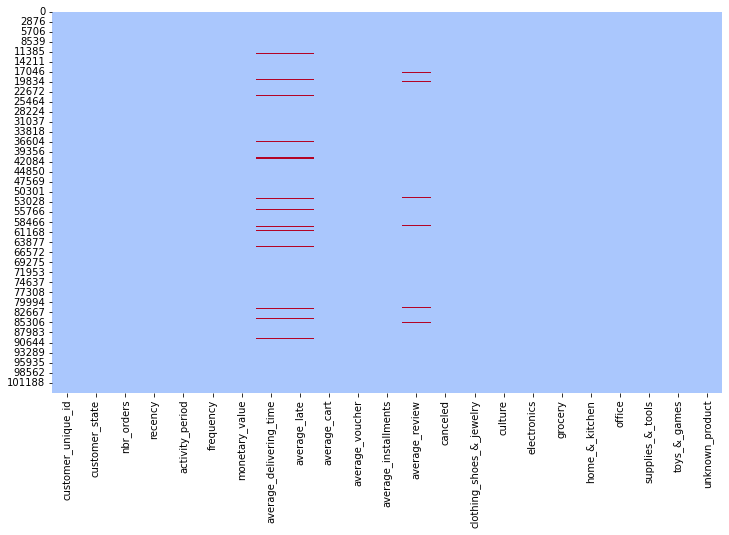

In [70]:
# Aperçu du volume d'informations manquantes :
plt.figure(figsize=(12,7))
sns.heatmap(data.isna(),cbar=False, cmap="coolwarm", center=0.25)

#### 2) Commentaires :

#### 3) Commandes annulées :

In [71]:
# Suppression des clients qui ont annulé toutes leurs commandes :
data = data[data["canceled"]<data["average_cart"]*data["nbr_orders"]]

### B - Typage :

#### 1) Aperçu :

In [72]:
# Types de variables :
data.dtypes

customer_unique_id                   object
customer_state                       object
nbr_orders                            int64
recency                     timedelta64[ns]
activity_period             timedelta64[ns]
frequency                           float64
monetary_value                      float64
average_delivering_time     timedelta64[ns]
average_late                timedelta64[ns]
average_cart                        float64
average_voucher                     float64
average_installments                float64
average_review                      float64
canceled                              int32
clothing_shoes_&_jewelry              int32
culture                               int32
electronics                           int32
grocery                               int32
home_&_kitchen                        int32
office                                int32
supplies_&_tools                      int32
toys_&_games                          int32
unknown_product                 

#### 2) Commentaires :

### C - Vérification de la cohérence des variables :

#### 1) customer_state :

In [73]:
# différentes valeurs de la variable :
data["customer_state"].unique()

array(['SP', 'SC', 'MG', 'PR', 'RJ', 'RS', 'PA', 'GO', 'ES', 'BA', 'MA',
       'MS', 'CE', 'DF', 'RN', 'PE', 'MT', 'AM', 'AP', 'AL', 'RO', 'PB',
       'TO', 'PI', 'AC', 'SE', 'RR'], dtype=object)

#### 2) recency :

In [74]:
# Classement des valeurs :
data["recency"].sort_values()

48440     1 days 21:14:16
32322    14 days 22:34:49
29073    17 days 02:00:09
26317    22 days 08:50:03
36450    23 days 05:31:00
               ...       
60597   744 days 19:24:15
8683    744 days 20:16:42
59529   745 days 00:33:28
23474   763 days 05:13:40
89328   773 days 20:14:59
Name: recency, Length: 95563, dtype: timedelta64[ns]

In [75]:
# Conversion
data["recency"]=pd.to_timedelta(data["recency"]).dt.days

#### 3) activity_period :

In [76]:
# Classement des valeurs :
data["activity_period"].sort_values()

71928    50 days 02:29:41
54053    50 days 02:38:18
569      50 days 03:11:50
89236    50 days 03:11:55
67006    50 days 05:04:19
               ...       
8683    744 days 20:16:42
59529   745 days 00:33:28
12389   745 days 07:45:28
23474   763 days 05:13:40
89328   773 days 20:14:59
Name: activity_period, Length: 95563, dtype: timedelta64[ns]

In [77]:
# Conversion
data["activity_period"]=pd.to_timedelta(data["activity_period"]).dt.days

#### 4) nbr_orders :

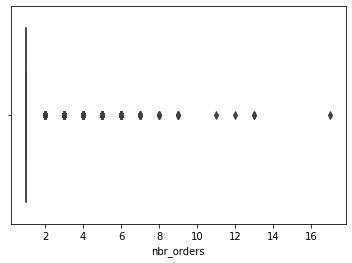

In [78]:
# Visualisation de la distribution :
plt.figure()
sns.boxplot(x=data["nbr_orders"])
plt.show()

#### 6) frequency :

In [79]:
# Classement des valeurs :
data["frequency"].sort_values()

28808    0.021918
85246    0.024658
34831    0.024658
94368    0.038356
64844    0.038356
           ...   
60636    2.038356
24222    2.038356
97747    2.038356
59529    2.041096
23474    2.090411
Name: frequency, Length: 95563, dtype: float64

#### 7) monetary_value :

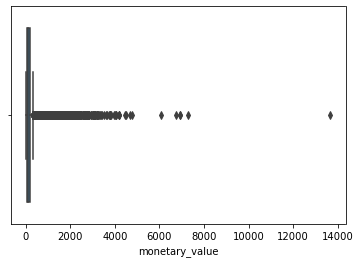

In [80]:
# Visualisation de la distribution :
plt.figure()
sns.boxplot(x=data["monetary_value"])
plt.show()

In [81]:
# Affichage de l'outlier :
data[data["monetary_value"]>12000]

,customer_unique_id,customer_state,nbr_orders,recency,activity_period,frequency,monetary_value,average_delivering_time,average_late,average_cart,average_voucher,average_installments,average_review,canceled,clothing_shoes_&_jewelry,culture,electronics,grocery,home_&_kitchen,office,supplies_&_tools,toys_&_games,unknown_product
6966,0a0a92112bd4c708ca5fde585afaa872,RJ,1,384,384,1.052055,13664.08,18 days 02:57:37,-6 days +18:22:29,1.0,0.0,1.0,1.0,0,0,0,1,0,0,0,0,0,0


#### 8) average_delivering_time :

In [82]:
# Classement des valeurs :
data["average_delivering_time"].dropna().sort_values()

55078     0 days 12:48:07
75252     0 days 18:45:10
17724     0 days 20:31:39
20259     0 days 20:43:20
16115     0 days 21:22:41
               ...       
24227   194 days 15:12:24
76010   194 days 20:24:15
4066    195 days 15:12:59
75358   208 days 08:26:32
30656   209 days 15:05:12
Name: average_delivering_time, Length: 93351, dtype: timedelta64[ns]

In [83]:
# Conversion
data["average_delivering_time"]=pd.to_timedelta(data["average_delivering_time"]).dt.days

#### 9) average_late :

In [84]:
# Classement des valeurs :
data["average_late"].dropna().sort_values()

36592   -147 days +23:36:47
32111   -140 days +14:27:45
66978   -135 days +16:35:43
29905   -109 days +13:49:07
72482    -84 days +22:18:23
                ...        
24227     166 days 14:00:04
57156     167 days 17:00:07
73517     175 days 20:51:31
30656     181 days 14:36:39
75358     188 days 23:24:07
Name: average_late, Length: 93351, dtype: timedelta64[ns]

In [85]:
# Conversion
data["average_late"]=pd.to_timedelta(data["average_late"]).dt.days

#### 10) average_cart :

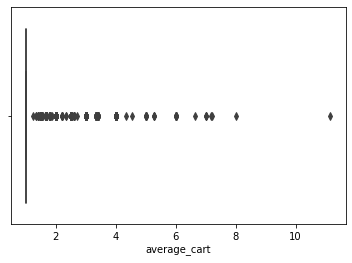

In [86]:
# Visualisation de la distribution :
plt.figure()
sns.boxplot(x=data["average_cart"])
plt.show()

In [87]:
# Affichage des outliers :
data[data["average_cart"]>15]

,customer_unique_id,customer_state,nbr_orders,recency,activity_period,frequency,monetary_value,average_delivering_time,average_late,average_cart,average_voucher,average_installments,average_review,canceled,clothing_shoes_&_jewelry,culture,electronics,grocery,home_&_kitchen,office,supplies_&_tools,toys_&_games,unknown_product


#### 11) average_voucher :

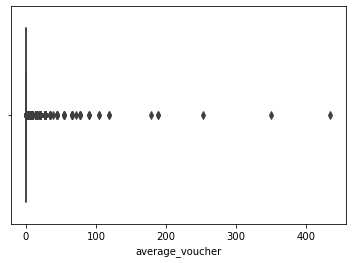

In [88]:
# Visualisation de la distribution :
plt.figure()
sns.boxplot(x=data["average_voucher"])
plt.show()

#### 12) average_installments :

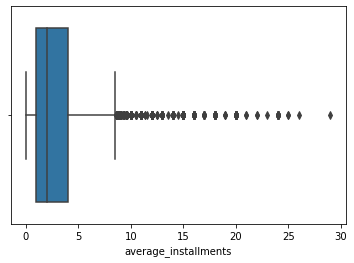

In [89]:
# Visualisation de la distribution :
plt.figure()
sns.boxplot(x=data["average_installments"])
plt.show()

In [90]:
# Remplacement des valeurs nulles par "1" :
data["average_installments"].replace(0,1, inplace=True)

#### 13) average_review :

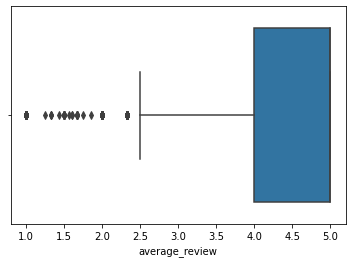

In [91]:
# Visualisation de la distribution :
plt.figure()
sns.boxplot(x=data["average_review"])
plt.show()

#### 14) canceled :

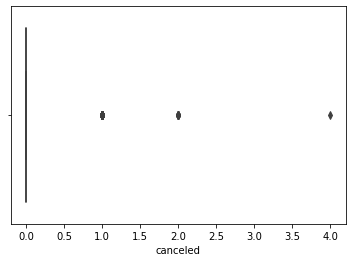

In [92]:
# Visualisation de la distribution :
plt.figure()
sns.boxplot(x=data["canceled"])
plt.show()

In [93]:
# Clients ayant annulé plus de deux articles commandés :
data[data["canceled"]>=2]

,customer_unique_id,customer_state,nbr_orders,recency,activity_period,frequency,monetary_value,average_delivering_time,average_late,average_cart,average_voucher,average_installments,average_review,canceled,clothing_shoes_&_jewelry,culture,electronics,grocery,home_&_kitchen,office,supplies_&_tools,toys_&_games,unknown_product
7126,46450c74a0d8c5ca9395da1daac6c120,SC,3,61,85,0.076712,3184.340000,8.0,-19.0,1.000000,0.0,4.000000,1.000000,2,0,0,0,0,0,0,0,1,2
7806,abfe742e782fb10f5c824fcb849e5cd1,SP,6,426,426,0.194521,88.526667,14.0,-14.0,2.000000,0.0,8.000000,5.000000,2,0,0,0,0,4,0,0,0,2
14565,ff36be26206fffe1eb37afd54c70e18b,SP,3,56,82,0.073973,92.760000,NaN,NaN,1.000000,0.0,1.666667,3.000000,2,0,0,0,0,1,0,0,0,2
21310,01ea7dfdac01a4e8fbe2902b73510b20,RJ,3,250,250,0.227397,163.936667,13.0,-14.0,1.666667,0.0,5.000000,2.333333,2,0,0,0,0,2,1,0,0,0
26317,ba84da8c159659f116329563a0a981dd,RJ,3,22,53,0.046575,94.630000,4.0,-26.0,1.000000,0.0,1.000000,1.000000,2,0,0,0,0,0,1,0,0,2
32322,af5454198a97379394cacf676e1e96cb,SP,3,14,69,0.063014,197.550000,7.0,-5.0,1.000000,0.0,1.000000,1.000000,2,0,0,0,0,0,0,1,0,2
54026,cc14ea7099959d91a17c9d7c3a46721d,ES,7,517,524,0.202740,242.697143,13.0,-12.0,3.000000,0.0,5.285714,5.000000,4,0,0,0,0,0,0,7,0,0
54687,230a1e9f42924d41f37fd22a1d4a9707,SP,3,42,84,0.076712,69.460000,4.0,-10.0,1.000000,0.0,1.000000,5.000000,2,0,0,0,0,0,0,1,0,2
70942,e892e5924e6ce2d1b684a926b4f7e258,RS,2,575,575,0.786301,70.080000,NaN,NaN,2.000000,0.0,7.000000,1.000000,2,0,0,2,0,0,0,0,0,0
81729,2f96790fba243100730c8d1185dd2f25,SP,2,739,739,1.010959,140.220000,7.0,-45.0,2.000000,0.0,2.000000,5.000000,2,2,0,0,0,0,0,0,0,0


#### 15) Variables catégorielles encodées :

In [94]:
# aperçu : clothing_shoes_&_jewelry
data[["clothing_shoes_&_jewelry","culture","electronics","grocery","home_&_kitchen",
      "office","supplies_&_tools","toys_&_games","unknown_product"]].describe()

,clothing_shoes_&_jewelry,culture,electronics,grocery,home_&_kitchen,office,supplies_&_tools,toys_&_games,unknown_product
count,95563.000000,95563.000000,95563.000000,95563.000000,95563.000000,95563.000000,95563.000000,95563.000000,95563.000000
mean,0.279501,0.020269,0.136402,0.012704,0.338426,0.114228,0.064648,0.092222,0.022226
std,0.492111,0.145596,0.358692,0.117999,0.555946,0.340432,0.261737,0.299890,0.150301
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,14.000000,3.000000,4.000000,8.000000,13.000000,7.000000,8.000000,6.000000,3.000000


## IV - ANALYSE EXPLORATOIRE :

### A - Analyse des variables :

#### 1) Histogramme des distributions des variables numériques :

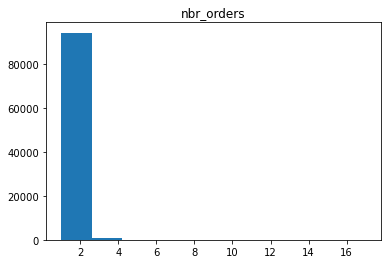

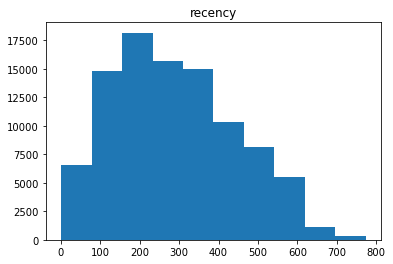

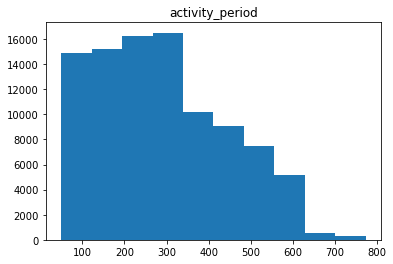

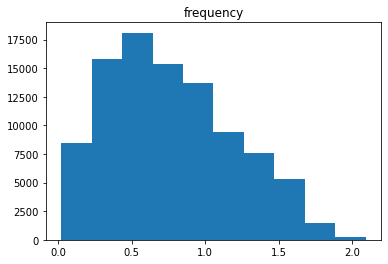

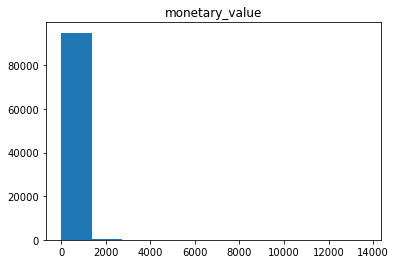

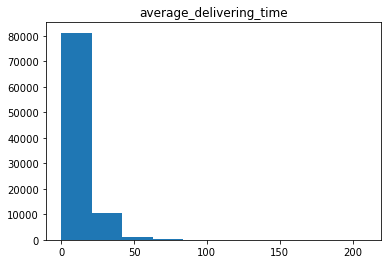

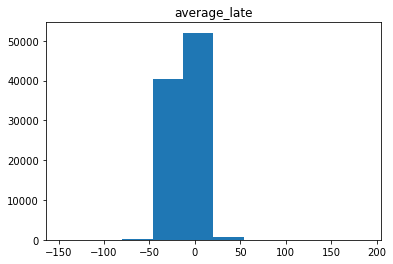

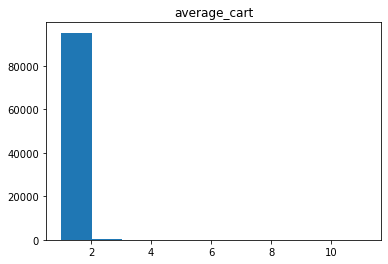

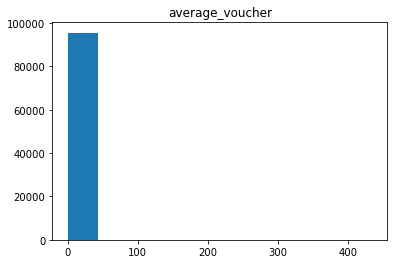

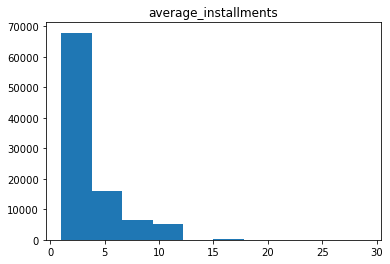

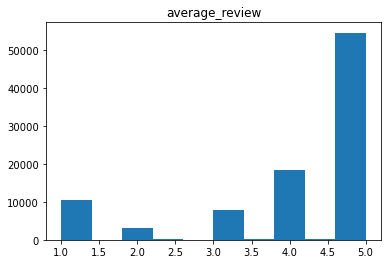

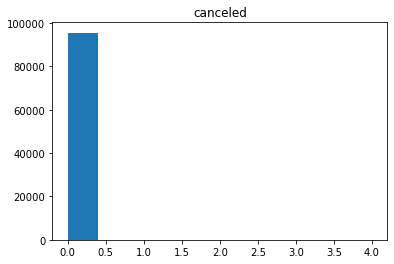

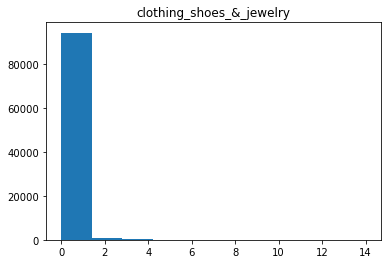

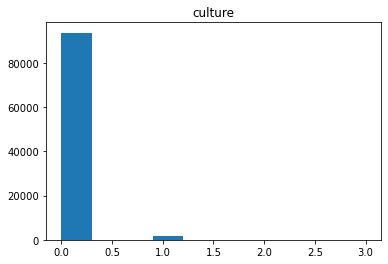

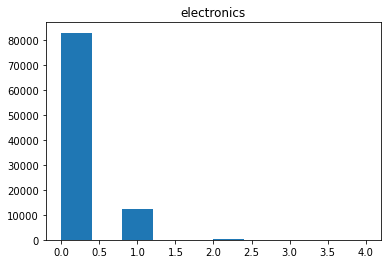

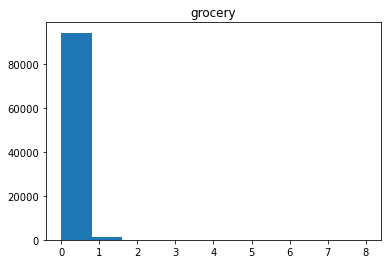

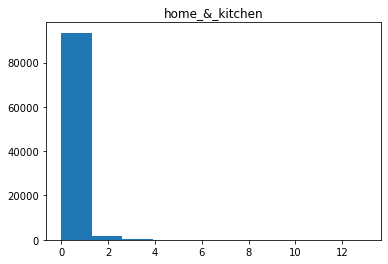

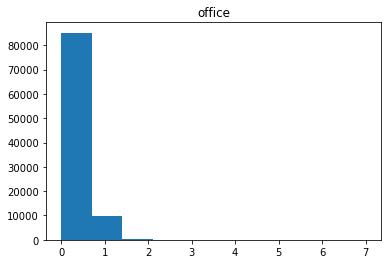

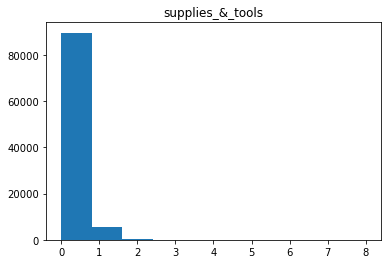

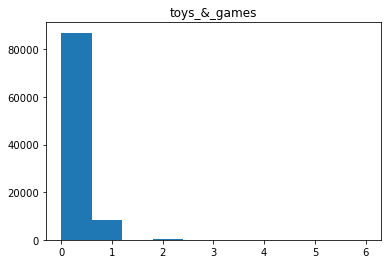

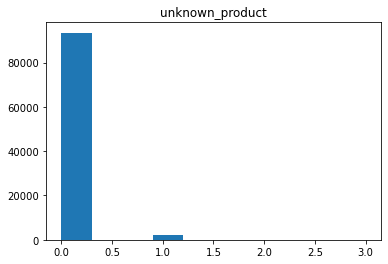

In [95]:
# Affichage des distributions des variables :

import matplotlib as mpl
mpl.rc('figure', max_open_warning = 0)

for c in data.select_dtypes(np.number).columns :
    plt.figure()
    plt.hist(data.select_dtypes(np.number)[c])
    plt.title(f"{c}")

#### 2) Corrélations entre les variables :

<AxesSubplot:>

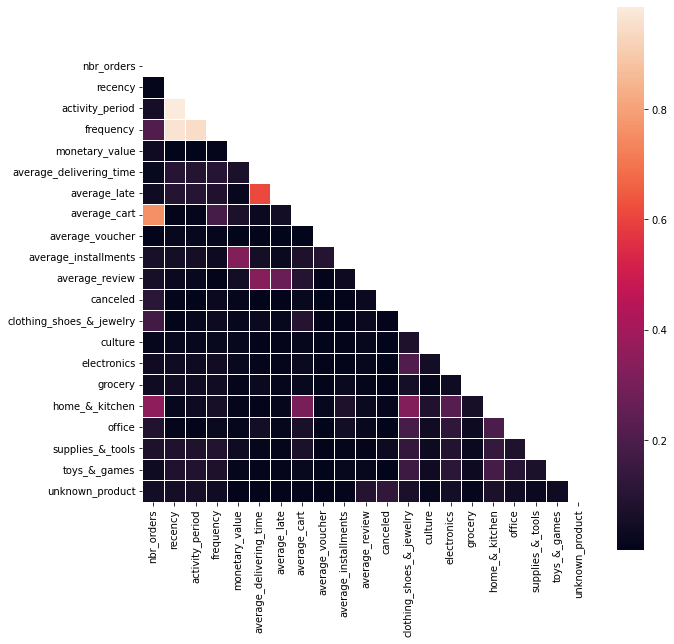

In [101]:
# Matrice de corrélation :
plt.figure(figsize=(10,10))
mask=np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(abs(data.corr()), mask=mask, square=True, linewidth=.5)

### B - Profil des clients :

#### 1) Client type :

In [ ]:
# De quel État vient-il ?
data["customer_state"].mode()

In [ ]:
# Est-il inscrit sur le site depuis longtemps ?
data["activity_period"].mean()

In [ ]:
# Combien de commandes a-t-il effectué-t-il sur le site ?
data["nbr_orders"].mode()

In [ ]:
# Quel est son panier moyen ?
data["average_cart"].mode()

In [ ]:
# Qu'achète-t-il ?
data[["clothing_shoes_&_jewelry","culture","electronics","grocery","home_&_kitchen",
      "office","supplies_&_tools","toys_&_games","unknown_product"]].sum().sort_values()

In [ ]:
# Quel est la fréquence de ses achats ?
data["frequency"].mean()

In [ ]:
# Quel est le montant total de ses dépenses :
data["monetary_value"].mean()

In [ ]:
# Est-il satisfait des services de l'entreprise ?
data["average_review"].mean()

#### 2) Influence de l'État de domiciliation :

In [ ]:
# Importance de la clientèle par État fédéraux
pie_state = data.groupby("customer_state")["customer_unique_id"].count()
plt.figure(figsize=(5,5))
plt.title("Nombre de clients par États Fédéraux")
plt.pie(pie_state, labels=pie_state.index)
plt.show()

In [ ]:
# Importance de la domiciliation sur le montant dépensé :
plt.figure(figsize=(6,7))
plt.title("Influence de l'État de résidence sur les dépenses")
sns.boxplot(x=data["monetary_value"], y=data["customer_state"], showfliers=False)

In [ ]:
# ANOVA monetary_value ~ customer_state :
anova_state_money = smf.ols("monetary_value ~ customer_state" 
                            ,data=data).fit()
anova_state_money.summary()

In [ ]:
# Influence de la domiciliation sur le type d'achat :
plt.figure(figsize=(10,6))
plt.title("Influence de l'État de résidence sur le type d'achats")
sns.heatmap(data[["customer_state","clothing_shoes_&_jewelry","culture","electronics","grocery","home_&_kitchen",
      "office","supplies_&_tools","toys_&_games","unknown_product"]].groupby("customer_state").sum().T)

In [ ]:
# Table de contingence et chi2 :
datachi2_pivot = datachi2.pivot_table(index="product_category_name_english", columns="customer_state",
                                      values="nbr_orders", aggfunc=len, margins=True)
tx = datachi2_pivot.loc[:,["All"]]
ty = datachi2_pivot.loc[["All"],:]
n = len(datachi2)
indep = tx.dot(ty) / n

c = datachi2_pivot.fillna(0)
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
table

In [ ]:
# Heatmap chi2 :
plt.figure(figsize=(20,10))
sns.heatmap(table.iloc[:-1,:-1])
plt.title("Corrélation entre le sexe des clients et la catégorie de produit")
plt.xlabel("catégorie de produits")
plt.ylabel("Sexe de clients")
plt.show()

Les valeurs de chi2 entre l'État de domiciliation du client et le type d'achat est très faible (moins de 0.03 au général).

## V - EXPORT DU DATAFRAME TRANSFORMÉ ET NETTOYÉ :

### A) Dernières transformations :

#### 1) Suppression de variables non utiles à la segmentation :

In [ ]:
# Suppression des variables : 
data.drop(columns=["average_delivering_time","average_late","customer_state"], inplace=True)

#### 2) Imputation des valeurs manquantes à la variable "average_review" :

In [ ]:
# Imputation des notes manquantes :
data["average_review"].fillna(round(data["average_review"].mean()), inplace=True)

#### 3) Imputation des valeurs manquantes des variables "average_voucher" et "average_installments" :

In [ ]:
# Imputation des valeurs manquantes :
data["average_voucher"].fillna(data["average_voucher"].mode()[0], inplace=True)
data["average_installments"].fillna(data["average_installments"].mode()[0], inplace=True)

### B - Export :

In [ ]:
# Export au format CSV :
data.to_csv("cleaned_data.csv")